### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
# %pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data and model

In [2]:
from tqdm import tqdm
import numpy as np

In [3]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [4]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Tokenize the data

In [6]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [7]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [8]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [9]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
model = model.to(device)

In [11]:
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=6
)

In [12]:
pred = []
true = []

for batch in tqdm(val_loader):
    with torch.no_grad():
        predicted = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
        pred.extend(torch.argmax(predicted.logits, dim=1).cpu().data.tolist())
        true.extend(batch['labels'].data.tolist())

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [02:41<00:00,  1.96it/s]


In [13]:
accuracy = np.mean(np.array(pred) == np.array(true))
print(accuracy)

0.9083848627256987


In [14]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [4]:
MODEL_NAME = './models/models--microsoft--deberta-v3-base/snapshots/8ccc9b6f36199bec6961081d44eb72fb3f7353f3'
model = transformers.AutoModel.from_pretrained(MODEL_NAME)
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
D:\Dev\jupyter\projects\Data Science\venvs\venv_yandex_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [5]:
model

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): StableDropout()
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): StableDropout()
            (dropout): StableDropout()
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): StableDropout()
          )
        )
        (intermedia

In [5]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [6]:
tokenizer.decode(qqp_preprocessed['train'][0]['input_ids'])

'[CLS] How is the life of a math student? Could you describe your own experiences?[SEP] Which level of prepration is enough for the exam jlpt5?[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
class SameSentencePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(MODEL_NAME)
        self.pooler = nn.Linear(768, 768)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(768, 2)

    def forward(self, inp, device=device):
        output = self.backbone(
            input_ids=inp['input_ids'].to(device),
            attention_mask=inp['attention_mask'].to(device),
            token_type_ids=inp['token_type_ids'].to(device)
        )['last_hidden_state'][:, 0, :]
        
        pooler_output = self.pooler(output)
        pooler_output = self.activation(pooler_output)
        pooler_output = self.dropout(pooler_output)
        
        output = self.classifier(pooler_output)
        return output

In [11]:
# torch.cuda.empty_cache()

# model = SameSentencePredictor()
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [12]:
# # compute accuracy
# model.eval()
# val_set = qqp_preprocessed['validation']
# val_loader = torch.utils.data.DataLoader(
#     val_set, batch_size=128, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=6
# )

# pred = []
# true = []

# for batch in tqdm(val_loader):
#     with torch.no_grad():
#         predicted = model(batch)
#         pred.extend(torch.argmax(predicted, dim=1).cpu().data.tolist())
#         true.extend(batch['labels'].data.tolist())

# print(np.mean(np.array(pred) == np.array(true)))

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [03:46<00:00,  1.40it/s]

0.6318575315359881


In [13]:
# model

SameSentencePredictor(
  (backbone): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
     

In [9]:
train_set = qqp_preprocessed['train']

train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True, collate_fn=transformers.default_data_collator, num_workers=6
)

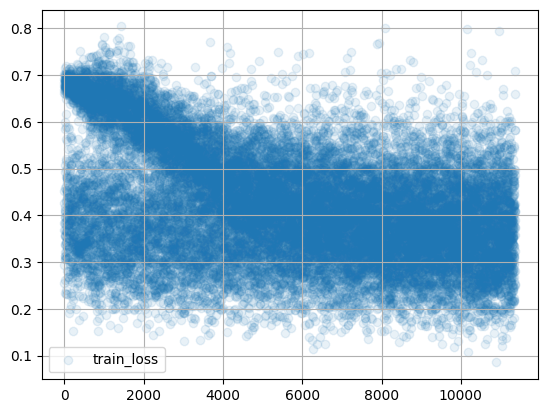

11371it [1:43:39,  1.83it/s]


In [15]:
# from IPython.display import clear_output
# import matplotlib.pyplot as plt

# train_history = []
# model.train()

# for epoch in range(2):
#     for i, batch in tqdm(enumerate(train_dataloader)):
#         logits = model(batch)

#         loss = F.cross_entropy(logits, batch['labels'].to(device))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_history.append((i, loss.item()))
#         if (i + 1) % 50 == 0:
#             clear_output(True)
#             plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
#             plt.legend(); plt.grid(); plt.show()

In [17]:
# torch.save(model.state_dict(), './models/sentence.pth')

In [11]:
model = SameSentencePredictor()
model.load_state_dict(torch.load('./models/sentence.pth'))
model.to(device)
model.eval()

SameSentencePredictor(
  (backbone): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
     

In [13]:
model.eval()
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=6
)

pred = []
true = []

for batch in tqdm(val_loader):
    with torch.no_grad():
        predicted = model(batch)
        pred.extend(torch.argmax(predicted, dim=1).cpu().data.tolist())
        true.extend(batch['labels'].data.tolist())

print(np.mean(np.array(pred) == np.array(true)))

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [03:54<00:00,  1.34it/s]

0.8527578530793964


### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [59]:
def duplicate_finder(text, model, train_set, batch_size=32, topn=5):
    scores_result = []
    texts_result = []
    
    for i in tqdm(range(int(np.ceil(len(train_set) / batch_size)))):
        train_texts = train_set[i*batch_size:(i+1)*batch_size]
        size = len(train_texts['text1']) + len(train_texts['text2'])
        
        inp = tokenizer([text]*size, train_texts['text1']+train_texts['text2'], padding='max_length',
                         max_length=MAX_LENGTH, truncation=True, return_tensors='pt')
        with torch.no_grad():
            predicted = model(inp)
            
        scores = F.softmax(predicted, dim=-1).cpu().detach().numpy()[:, 1]
        indices = np.argsort(scores)[-topn:][::-1]
        texts = np.array(train_texts['text1']+train_texts['text2'])[indices].tolist()

        scores_result.extend(scores[indices])
        texts_result.extend(texts)
        
    total_scores = np.array(scores_result)
    total_indices = np.argsort(total_scores)[-topn:][::-1]
    
    return total_scores[total_indices].tolist(), np.array(texts_result)[:topn].tolist()

In [60]:
results = duplicate_finder('How is the life of a math student?', model, train_set.select(range(5000)), batch_size=256)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/it]


In [61]:
results

([0.7795463800430298,
  0.07153316587209702,
  0.06952144205570221,
  0.05856863409280777,
  0.04253719002008438],
 ['How is the life of a math student? Could you describe your own experiences?',
  "How bad can Trump's election as president be for students aspiring to study in US?",
  'What is the purpose of our existence? I mean why do we exist?',
  'What are micronutrients and macronutrients? How do you distinguish the difference between micronutrients and macronutrients?',
  'How does an IQ test work and what is determined from an IQ test?'])

__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.